In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install py7zr

import py7zr

# 압축 해제할 파일들의 경로
files_to_extract = [
    '/content/drive/MyDrive/feature_training/feature_training.7z',
    '/content/drive/MyDrive/label_training/label_training.7z'
]

# 각 파일을 반복하여 압축 해제
for file_path in files_to_extract:
    output_path = file_path.rsplit('/', 1)[0]  # 파일이 있는 동일한 폴더 내에 압축 해제
    with py7zr.SevenZipFile(file_path, 'r') as archive:
        archive.extractall(path=output_path)
    print(f"압축 해제 완료: {file_path}")

압축 해제 완료: /content/drive/MyDrive/feature_training/feature_training.7z
압축 해제 완료: /content/drive/MyDrive/label_training/label_training.7z


In [16]:
# 독립변수 종속변수 모두 수치형이어야 딥러닝이 돌아간다.

# - 원태찬 작성.
# : 팀프로젝트를 했었던 내용이었지만 이미지 분류는 받지 못한 파일이었어서 혼자 작성함.

# training 데이터에서 label과 짝이 안 맞는 데이터가 있어서 이를 걸러내고 짝이 맞는 것만 추출하기

# - training(학습), validation(검증)의 2가지 데이터가 있다.
# 그런데 training데이터는 colab pro를 사용하였으나, 메모리 부족으로 validation데이터로 학습함.
import os
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.model_selection import _split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from keras.preprocessing import image
import re
from sklearn.preprocessing._label import LabelEncoder
from google.colab import drive

# json 파일 읽어서 DataFrame화 하기
pd.set_option('display.max_columns', None)

# 마지막에 validation -> training
path = '/content/drive/MyDrive/label_training/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.json')]

import json

dict_list = []
for i in file_list_py:
    for line in open((path+i),"r"):
        # print(line)
        # re.sub('._META','', line['image_file_name'])
        dict_list.append(json.loads(line))
df = pd.DataFrame(dict_list)
print(len(df))

# 0->0, 1,2,3->1로 바꾸는 작업
for i in range(1,7):
  df[f'value_{i}'] = df[f'value_{i}'].map({'0':0,'1':1,'2':1,'3':1})
df['구분'] = '복합성'


# label 지정
# +  : 123
# -   : 0
# +- : 0123
for i in range(len(df)):
    if df.iloc[i][2:8].sum() == 0:
        df.loc[i, '구분'] = '양호'
    elif (df['value_1'][i] == 1) & (df['value_2'][i] == 0) & (df['value_3'][i] == 0) & (df['value_4'][i] == 0) & (df['value_5'][i] == 0) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '건성'
    elif (df['value_1'][i] == 0) & (df['value_2'][i] == 1) & (df['value_3'][i] == 0) & (df['value_4'][i] == 0) & (df['value_5'][i] == 0) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '지성'
    elif (df['value_1'][i] in [0,1]) & (df['value_2'][i] == 0) & (df['value_3'][i] == 1) & (df['value_4'][i] == 0) & (df['value_5'][i] == 0) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '민감성'
    elif (df['value_1'][i] in [0,1]) & (df['value_2'][i] == 1) & (df['value_3'][i] == 1) & (df['value_4'][i] == 0) & (df['value_5'][i] in [0,1]) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '지루성'
    elif (df['value_1'][i] in [0,1]) & (df['value_2'][i] in [0,1]) & (df['value_3'][i] == 0) & (df['value_4'][i] == 1) & (df['value_5'][i] in [0,1]) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '염증성'
    elif (df['value_1'][i] in [0,1]) & (df['value_2'][i] in [0,1]) & (df['value_3'][i] == 0) & (df['value_4'][i] == 0) & (df['value_5'][i] == 1) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '비듬성'
    elif (df['value_1'][i] == 0) & (df['value_2'][i] == 0) & (df['value_3'][i] == 0) & (df['value_4'][i] == 0) & (df['value_5'][i] == 0) & (df['value_6'][i] == 1):
        df.loc[i, '구분'] = '탈모성'
    else:
        df.loc[i, '구분'] = '복합성'


print('양호 :', (df['구분'] == '양호').value_counts()[True])
print('건성 :', (df['구분'] == '건성').value_counts()[True])
print('지성 :', (df['구분'] == '지성').value_counts()[True])
print('민감성 :', (df['구분'] == '민감성').value_counts()[True])
print('지루성 :', (df['구분'] == '지루성').value_counts()[True])
print('염증성 :', (df['구분'] == '염증성').value_counts()[True])
print('비듬성 :', (df['구분'] == '비듬성').value_counts()[True])
print('탈모성 :', (df['구분'] == '탈모성').value_counts()[True])
print('복합성 :', (df['구분'] == '복합성').value_counts()[True])



# 이미지 불러오기 및 사이즈 조정 후 리스트에 추가
path = '/content/drive/MyDrive/feature_training/'
cv_img = [Image.open(os.path.join(path, img)).resize((200, 200)) for img in os.listdir(path) if img.endswith('.jpg')]


# 파일 이름 리스트로 가져오기
file_list = os.listdir('/content/drive/MyDrive/feature_training/')
file = []
for i in file_list:
    file.append(i)
file = pd.DataFrame(file, columns=["image_file_name"])


hap = pd.merge(df, file, on='image_file_name', how='inner')


array = hap.values
feature = array[:, [1]]
label = array[:, 8]

# 라벨인코더 (독립변수에서 문자를 숫자로 바꿈)
encoder = LabelEncoder()
encoder.fit(feature)
feature = encoder.transform(feature)


# label들 map시키기
dic = {'양호':0, '건성':1, '지성':2, '민감성':3, '지루성':4, '염증성':5, '비듬성':6, '탈모성':7, '복합성':8}
hap['구분'] = hap['구분'].map(dic)

# label 원핫인코딩, thin = [1. 0. 0.], normal = [0. 1. 0.], fat = [0. 0. 1.]
onehot = OneHotEncoder()
label = onehot.fit_transform(label[:, np.newaxis]).toarray()


# 이미지
# features: 이미지  (10000장)
# labels: 라벨링 데이터  (10000개)

10000
양호 : 143
건성 : 186
지성 : 996
민감성 : 758
지루성 : 3786
염증성 : 55
비듬성 : 979
탈모성 : 18
복합성 : 3079


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [17]:
def preprocess_img(img_path, target_size=(200, 200)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_tensor = np.array(img) / 255.0  # scaling into [0, 1]
    return img_tensor


# 이미지와 json파일 1:1만들어주기
path = "/content/drive/MyDrive/feature_training/"
target_size = 200
cv = []
for i in range(len(df)):
    file_list = df['image_file_name'][i]
    img_path = os.path.join(path, file_list)
    # 이미지를 NumPy Array로 로드
    # 이미지 배열 저장
    # 이미지 파일 열기
    img = Image.open(img_path)

    # 이미지 파일을 NumPy 배열로 변환
    img_arr = np.array(img)
    np.save("image_array.npy", img_arr)

    # 이미지 배열 로드
    img_arr = np.load("image_array.npy", allow_pickle=True)

    # img_arr = np.load(img_path, allow_pickle=True)
    # NumPy Array를 PIL Image 객체로 변환
    img_pil = Image.fromarray(img_arr)
    # PIL Image 객체를 target_size로 리사이즈
    img_resized = img_pil.resize((target_size, target_size))
    # PIL Image 객체를 NumPy Array로 변환
    img_tensor = np.array(img_resized)
    # img = image.Image(img_path, target_size=(target_size, target_size))
    # img_tensor = image.img_to_array(img)
    #정규화
    img_tensor = img_tensor.astype('float32')
    img_tensor /= 255.
    cv.append(img_tensor)

feature = cv
label = df['구분']

# label 원핫인코딩, thin = [1. 0. 0.], normal = [0. 1. 0.], fat = [0. 0. 1.]
onehot = OneHotEncoder()
label = onehot.fit_transform(np.array(label).reshape(-1, 1)).toarray()

"""
양호 : 143
건성 : 186
지성 : 996
민감성 : 758
지루성 : 3786
염증성 : 55
비듬성 : 979
탈모성 : 18
복합성 : 3079
"""
################# 이미지 증강, 이미지 축소 삭제#########################
양호= df.loc[(df['구분'] == '양호')]
복합성= df.loc[(df['구분'] == '복합성')]

3222 (200, 200, 3) (3222, 200, 200, 3)


In [40]:
import numpy as np
import os

# 이미지 전처리 함수
def preprocess_img(img_path):
    try:
        # 이미지 파일을 열고 RGB 형식으로 변환
        with Image.open(img_path).convert('RGB') as img:
            # 이미지 크기 조정
            img = img.resize((200, 200))  # 예시 크기
            # 이미지를 NumPy 배열로 변환
            img_array = np.array(img)
            return img_array
    except IOError as e:
        # 이미지 로딩 실패 시, 콘솔에 에러 메시지 출력
        print(f"Error loading image {img_path}: {e}")
        return None

# DataFrame 'df'와 경로 'path'가 정의되어 있어야 함.
dict_x = {}
y_dict = {}

# 이미지 데이터와 레이블 데이터 준비
for scalp_type in ['양호','건성', '지성', '민감성', '지루성', '비듬성', '염증성', '탈모성','복합성']:
    file_list = df.loc[df['구분'] == scalp_type]['image_file_name']
    dict_x[scalp_type] = [preprocess_img(os.path.join(path, img_name)) for img_name in file_list]
    y_dict[scalp_type] = np.array([scalp_type] * len(dict_x[scalp_type]))

# 이미지 데이터와 레이블 데이터를 하나의 배열로 결합
X_combined = np.concatenate([np.array(v) for v in dict_x.values()])
y_combined = np.concatenate([v for v in y_dict.values()])

# X_combined와 y_combined에서 None 값을 확인하고 제거하는 과정
valid_indices = [i for i, x in enumerate(X_combined) if x is not None]
X_combined_clean = np.array([X_combined[i] for i in valid_indices])
y_combined_clean = np.array([y_combined[i] for i in valid_indices])

print(np.shape(X_combined_clean))
print(np.shape(y_combined_clean))

(10000, 200, 200, 3)
(10000,)


In [50]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# 데이터 나누기
# test_size=0.3은 전체 데이터 중 30%를 테스트 데이터로, 70%는 훈련 데이터(예측)로 사용된다는 뜻이다.
x_train, x_test, y_train, y_test = train_test_split(X_combined_clean, y_combined_clean, test_size=0.3, random_state=42)

print(x_train.shape, y_train.shape)  # 훈련 데이터의 크기 출력
print(x_test.shape, y_test.shape)  # 테스트 데이터의 크기 출력

# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# 원핫인코딩
y_train_onehot = to_categorical(y_train, num_classes=9)
y_test_onehot = to_categorical(y_test, num_classes=9)

(7000, 200, 200, 3) (7000,)
(3000, 200, 200, 3) (3000,)


In [70]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
transfer_model = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(200,200,3))
transfer_model.trainable=False


model_resnet50 = Sequential([
     transfer_model,
     Conv2D(256, kernel_size=(3,3), input_shape=(200,200,3), padding='same', activation='relu'),
     BatchNormalization(),  # 정규화 레이어 추가
     MaxPooling2D(pool_size=(2,2)),
     Dropout(0.3),  # Dropout 비율 조정

     Conv2D(128, (3,3), padding='same', activation='relu'),
     BatchNormalization(),  # 정규화 레이어 추가
     MaxPooling2D(pool_size=(2,2)),
     Dropout(0.3),  # 과적합 방지를 위한 Dropout 적용

     Flatten(),
     Dense(512, activation='relu'),
     Dropout(0.5),  # 더 큰 Dropout 비율 적용
     Dense(256, activation='relu'),
     Dropout(0.5),  # 같은 이유로 Dropout 적용
     Dense(9, activation='softmax')
])


In [71]:
# 컴파일
# Adam(Adaptive Moment Estimation)은 경사하강법(Optimization) 알고리즘 중 하나로, 딥러닝에서 가장 많이 사용되는 최적화 알고리즘 중 하나이다.
# 경사하강법은 모델의 손실 함수에 최솟값을 구하는 것을 뜻한다.
# categorical_crossentropy는 분류 문제에서 많이 사용되는 손실 함수 중 하나임.
# metrics는 모델의 평가 지표로써 acc는 정확도를 사용한다는 뜻임.
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [72]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
earlystop = EarlyStopping(monitor='val_loss',  # 모니터링 대상 성능 지표
                          patience=3,  # 성능 지표가 개선되지 않는 에포크를 몇 번이나 허용할 것인가
                          verbose=1,  # 진행 상황을 출력
                          restore_best_weights=True)  # 가장 좋은 모델의 가중치를 복원할지 여부

# 모델 학습
history_resnet50 = model_resnet50.fit(x_train, y_train_onehot,
                                      epochs=20,
                                      batch_size=256,
                                      verbose=1,
                                      validation_split=0.2,
                                      callbacks=[earlystop])  # 콜백 리스트에 earlystop 추가

# loss: 1.3002 - accuracy: 0.4946 - val_loss: 1.3475 - val_accuracy: 0.4793

Epoch 1/20
22/22 [==============================] - 17s 427ms/step - loss: 1.9442 - accuracy: 0.3379 - val_loss: 2.2965 - val_accuracy: 0.3714
Epoch 2/20
22/22 [==============================] - 3s 140ms/step - loss: 1.5247 - accuracy: 0.4166 - val_loss: 1.7826 - val_accuracy: 0.4514
Epoch 3/20
22/22 [==============================] - 3s 140ms/step - loss: 1.4447 - accuracy: 0.4512 - val_loss: 1.6327 - val_accuracy: 0.4193
Epoch 4/20
22/22 [==============================] - 3s 140ms/step - loss: 1.3725 - accuracy: 0.4712 - val_loss: 1.4555 - val_accuracy: 0.4579
Epoch 5/20
22/22 [==============================] - 3s 141ms/step - loss: 1.3002 - accuracy: 0.4946 - val_loss: 1.3475 - val_accuracy: 0.4793
Epoch 6/20
22/22 [==============================] - 3s 134ms/step - loss: 1.2105 - accuracy: 0.5355 - val_loss: 1.3811 - val_accuracy: 0.4586
Epoch 7/20
22/22 [==============================] - 3s 135ms/step - loss: 1.1129 - accuracy: 0.5721 - val_loss: 1.4376 - val_accuracy: 0.4564
Epoch

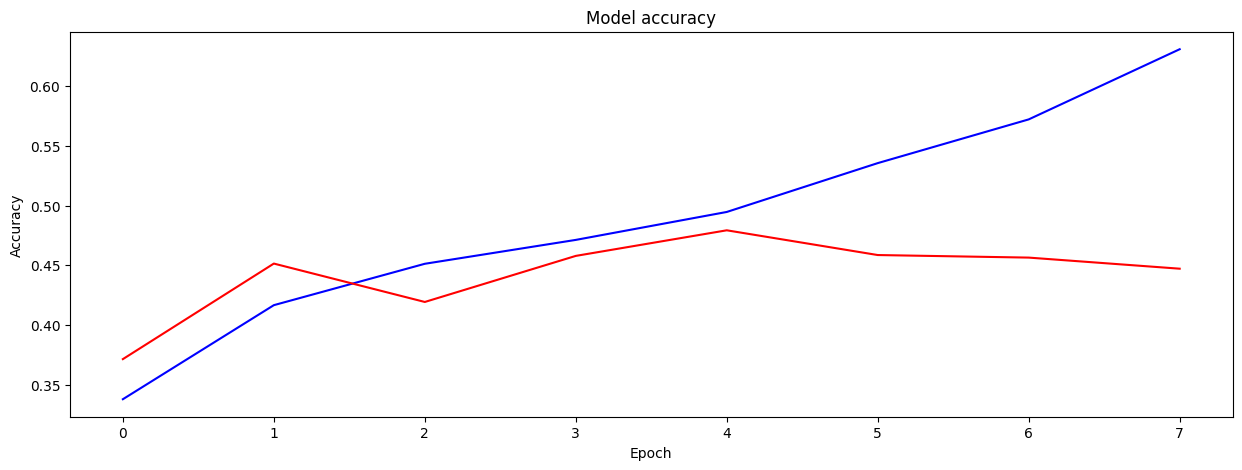

In [73]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['accuracy'], color='blue')
plt.plot(history_resnet50.history['val_accuracy'], color='red')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

1/1 [==============================] - 0s 30ms/step
예측값: [[1.3507573e-03 1.5838586e-01 2.4832056e-01 6.7184386e-03 7.2716485e-04
  6.8211666e-04 5.7924020e-01 4.1768919e-03 3.9805257e-04]]
예측 두피 종류: 비듬성


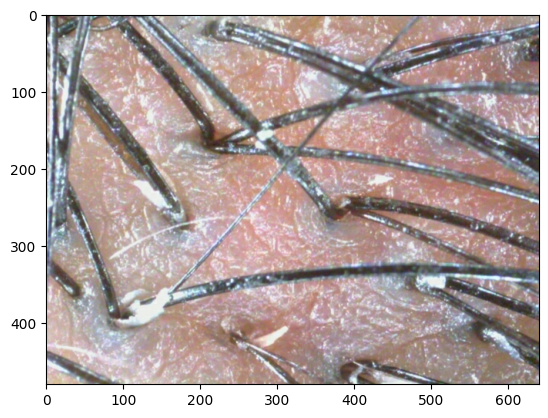

In [76]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 모델 예측 및 결과 출력 함수
def predict_and_display(img_path, model, classes):
    # 이미지 불러오기 및 전처리
    img = Image.open(img_path)
    img_array = np.array(img.resize((200, 200)))
    img_array = img_array.reshape(1, 200, 200, 3)  # 모델에 넣기 위해 4차원으로 변환

    # 예측하기
    pred = model.predict(img_array)
    pred_class_index = np.argmax(pred)
    pred_class = classes[pred_class_index]
    print(f'예측값: {pred}\n예측 두피 종류: {pred_class}')
    # 실제값 이미지 출력 (예측 이미지 재사용)
    plt.imshow(img)
    plt.show()

# 예측할 이미지의 경로
img_path = '/content/drive/MyDrive/0013_A2LEBJJDE00060O_1606386513159_6_BH.jpg'

# 두피 종류 레이블
classes = ['양호', '건성', '지성', '민감성', '지루성', '염증성', '비듬성', '탈모성', '복합성']

# 예측 및 결과 출력
predict_and_display(img_path, model_resnet50, classes)
